In [1]:
import torchrdit
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

from torchrdit.solver import RCWASolver, RDITSolver
from torchrdit.viz import plot2d
from torchrdit.utils import operator_proj, create_material
from tqdm import tqdm, trange

# Example 1 - GMRF with hexagonal unit cells with dispersive materials

This example simulates the guided-mode resonance filter (GMRF) using RCWA with dispersive materials. The device is composed of a dispersive SiC hexagonal grating layer, a SiN waveguide layer and a fused silica substrate.

------------------------------------
layer # Reflection
	material name: air
	permittivity: (1+0j)
	permeability: (1+0j)
------------------------------------
layer # 0
	material name: SiC
	thinkness = tensor([0.2300, 0.2300, 0.2300])
	dispersive: True
	homogeneous: False
	to be optimized: True
------------------------------------
layer # 1
	material name: SiN
	thinkness = tensor([0.3450, 0.3450, 0.3450])
	dispersive: False
	homogeneous: True
	to be optimized: False
------------------------------------
layer # Transmission
	material name: FusedSilica
	permittivity: (2.280100107192993+0j)
	permeability: (1+0j)
------------------------------------


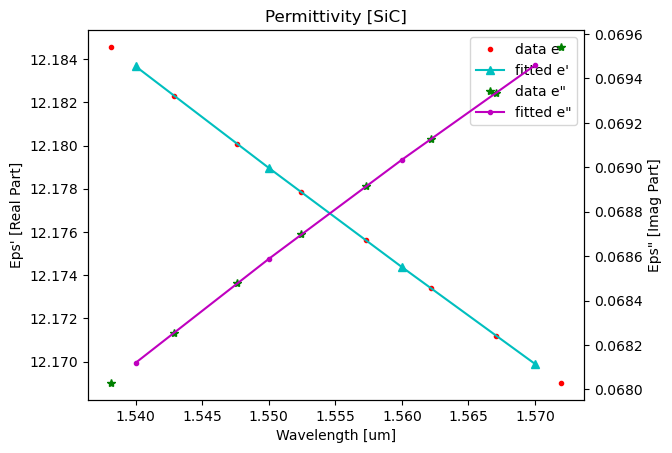

In [2]:
# units, normalizing all units to 'um'
um = 1
nm = 1e-3 * um
degrees = np.pi / 180

# angles of incident waves
theta = 0 * degrees
phi = 0 * degrees

# polarization
pte = 1
ptm = 0

# refractive index
n_SiO = 1.4496
n_SiN = 1.9360
n_fs = 1.5100

# dimensions of the cell
a = 1150 * nm
b = a * np.sqrt(3)

# radius of the holes on the top layer
r = 400 * nm

# thickness of each layer
h1 = torch.tensor(230 * nm, dtype=torch.float32)
h2 = torch.tensor(345 * nm, dtype=torch.float32)

# lattice vectors of the cell
t1 = torch.tensor([[a/2, -a*np.sqrt(3)/2]], dtype=torch.float32)
t2 = torch.tensor([[a/2, a*np.sqrt(3)/2]], dtype=torch.float32)

# creating materials
# all mateiral objects should be added to the 'materiallist' parameter when initializing the solver
material_sic = create_material(name='SiC', dielectric_dispersion=True, user_dielectric_file='materials/11242022/Si_C-e.txt', data_format='freq-eps', data_unit='thz')
material_sio2 = create_material(name='SiO2', dielectric_dispersion=True, user_dielectric_file='materials/11242022/SiO2-e.txt', data_format='freq-eps', data_unit='thz')
material_sin = create_material(name='SiN', permittivity=n_SiN**2)
material_fs = create_material(name='FusedSilica', permittivity=n_fs**2)

# Initialize the instance of the solver engine
dev1_dispersive = RCWASolver(batch_size=3,
            rdim = [512, 512],
            lam0 = np.array([1540 * nm, 1550 * nm, 1560 * nm, 1570 * nm]),
            lengthunit = 'um',
            t1 = t1,
            t2 = t2)

# update the material of the transmission layer
dev1_dispersive.update_trn_material(trn_material=material_fs)

# add a grating layer with patterns, the pattern can be updated later
dev1_dispersive.add_layer(material_name=material_sic,
              thickness=h1,
              is_homogeneous=False,
              is_optimize=True)

# add a homongeneous layer
dev1_dispersive.add_layer(material_name=material_sin,
              thickness=h2,
              is_homogeneous=True,
              is_optimize=False)

src1 = dev1_dispersive.add_source(theta = 0 * degrees,
                 phi = 0 * degrees,
                 pte = 1,
                 ptm = 0)

# print layer information
dev1_dispersive.get_layer_structure()

# create a source object
dev1_dispersive.display_fitted_permittivity()

In [3]:
# build hexagonal unit cell
rsq = dev1_dispersive.XO ** 2 + (dev1_dispersive.YO - b / 2) ** 2
mask = (rsq <= r ** 2)
rsq = dev1_dispersive.XO ** 2 + (dev1_dispersive.YO + b / 2) ** 2
mask = mask | (rsq <= r ** 2)
rsq = (dev1_dispersive.XO - a / 2) ** 2 + dev1_dispersive.YO ** 2
mask = mask | (rsq <= r ** 2)
rsq = (dev1_dispersive.XO + a / 2) ** 2 + dev1_dispersive.YO ** 2
mask = mask | (rsq <= r ** 2)

dev1_dispersive.update_er_with_mask(mask=mask, layer_index=0, set_grad = True)

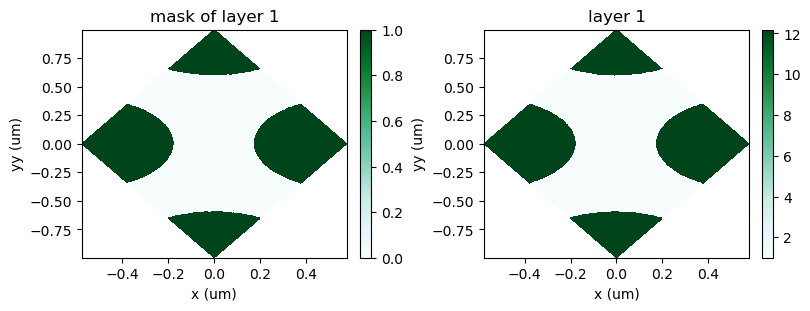

In [4]:
figa, axa = plt.subplots(1, 2, constrained_layout = True, figsize=(8,3));

plot2d(data=mask[0, :, :], layout=dev1_dispersive.get_layout(), func='real', fig_ax=axa[0], cmap='BuGn', labels=['x (um)','yy (um)'], title='mask of layer 1');
dev1_dispersive.plot_layer(layer_index=0, func='real', fig_ax=axa[1], cmap='BuGn', labels=('x (um)','yy (um)'), title='layer 1');

In [5]:
data = dev1_dispersive.solve(src1)# Example 1 - GMRF with hexagonal unit cells

In [6]:
print(f"The transmission efficiency is {data['TRN'][0,0] * 100}%")
print(f"The reflection efficiency is {data['REF'][0,0] * 100}%")

The transmission efficiency is 80.71495056152344%
The reflection efficiency is 17.1850643157959%


In [7]:
torch.sum(data['TRN'][0,0]).backward()

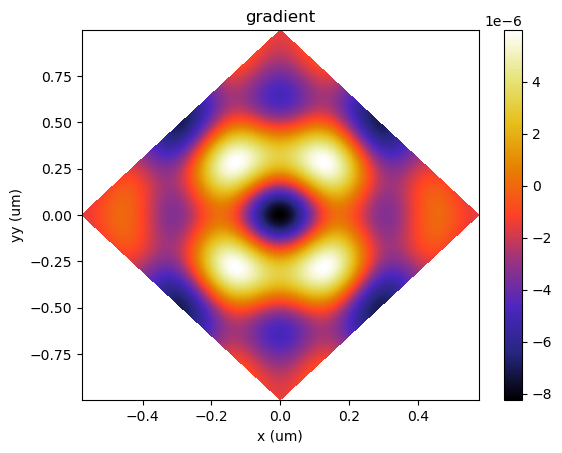

In [8]:
plot2d(data=dev1_dispersive.layers[0].ermat.grad[0, 0,:,:], layout=dev1_dispersive.get_layout(), func='real', cmap='CMRmap', labels=['x (um)','yy (um)'], title='gradient');